# XGBoost

In [81]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

## Load previously prepared data

In [13]:
df = pd.read_csv('data/laptop_train.csv')

In [14]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,Dell,Inspiron 3567,Notebook,15.6,Intel Core i3 7100U,6,Intel HD Graphics 620,Windows 10,2.30,1366x768,NaN,False,2.4,1000.0,HDD,0.0,NaN,6.129050
1,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Intel Core i5 7300HQ,8,Nvidia GeForce GTX 1050,Windows 10,2.50,1920x1080,IPSPanel,False,2.5,256.0,SSD,0.0,NaN,6.720220
2,Dell,XPS 13,Ultrabook,13.3,Intel Core i7 8550U,8,Intel UHD Graphics 620,Windows 10,1.20,1920x1080,NaN,False,1.8,256.0,SSD,0.0,NaN,7.364547
3,Asus,ZenBook UX305CA-UBM1,Ultrabook,13.3,Intel Core M 6Y30,8,Intel HD Graphics 515,Windows 10,1.20,1920x1080,IPSPanel,False,0.9,512.0,SSD,0.0,NaN,6.591674
4,Dell,Inspiron 3567,Notebook,15.6,Intel Core i3 6006U,4,AMD Radeon R5 M430,Linux,2.25,1366x768,NaN,False,2.0,1000.0,HDD,0.0,NaN,6.143370


In [15]:
df.columns

Index(['company', 'product', 'typename', 'inches', 'cpu', 'ram(GB)', 'gpu',
       'opsys', 'weight(kg)', 'resolution', 'screentype', 'touchscreen',
       'cpu(GHz)', 'memory_1_storage_gb', 'memory_1_type',
       'memory_2_storage_gb', 'memory_2_type', 'log_price'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1132 non-null   object 
 1   product              1132 non-null   object 
 2   typename             1132 non-null   object 
 3   inches               1132 non-null   float64
 4   cpu                  1132 non-null   object 
 5   ram(GB)              1132 non-null   int64  
 6   gpu                  1132 non-null   object 
 7   opsys                1132 non-null   object 
 8   weight(kg)           1132 non-null   float64
 9   resolution           1132 non-null   object 
 10  screentype           301 non-null    object 
 11  touchscreen          1132 non-null   bool   
 12  cpu(GHz)             1132 non-null   float64
 13  memory_1_storage_gb  1132 non-null   float64
 14  memory_1_type        1132 non-null   object 
 15  memory_2_storage_gb  1132 non-null   f

In [17]:
target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

In [21]:
en = LabelEncoder()
for cols in catFeatures:
    df[cols] = en.fit_transform(df[cols])
print('Dataframe encoded by Label encoding dimension : ', df.shape)

Dataframe encoded by Label encoding dimension :  (1132, 18)


In [22]:
df

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,218,3,15.6,41,6,44,4,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,8,267,1,15.6,49,8,63,4,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,525,4,13.3,69,8,51,4,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,547,4,13.3,33,8,39,4,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,218,3,15.6,39,4,19,1,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,6,101,3,14.0,44,4,40,4,1.54,3,2,0,2.3,500.0,1,0.0,3,6.907755
1128,0,69,3,15.6,48,8,74,4,2.40,3,2,0,2.5,256.0,3,1000.0,0,6.683361
1129,6,26,3,15.6,61,8,44,4,2.04,0,2,0,2.7,2000.0,1,0.0,3,6.444131
1130,6,295,3,15.6,9,6,23,4,2.04,3,2,0,2.9,1000.0,2,0.0,3,6.309900


In [23]:
X=df.drop('log_price', axis = 1).values
y=df['log_price'].values

## Hyperparameter tuning

In [70]:
import xgboost as xgb
from sklearn.metrics import r2_score


In [24]:
features = df.columns.tolist()
features.remove(target)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3)
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
print("R2 score:", r2_score(y_test,y_predict))


[22:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score: 0.9148946781501832


In [108]:
def run_xgb(train, validate, features, target, # must have parameters
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hypermarapeters
            colsample_bylevel=1, lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hypermarapeters
            rate_drop = 0.2, skip_drop=0.5, # hypermarapeters
            num_boost_round = 1000, early_stopping_rounds = 50, # hypermarapeters
            debug=True, eval_metric= ["rmse"], objective = "reg:linear", # config
            seed=2023, booster = "gbtree", tree_method="exact", grow_policy="depthwise",
           verbosity=1, silent=False): # config
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective',
          'seed', 'booster', 'tree_method', 'grow_policy', 'verbosity', 'silent']
    
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    params["lambda"]=lambdaX
    
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    train_history = dict()

    # Training algorithm
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    score = gbm.best_score

    # Transform the history of training into pandas DataFrame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Feature importance
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [109]:
test_size = 0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2023)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:linear, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, verbosity 1, silent False, 
Length train: 905
Length valid: 227
[0]	train-rmse:6.16809	valid-rmse:6.18281
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:5.98476	valid-rmse:5.99876
[2]	train-rmse:5.80706	valid-rmse:5.82111
[3]	train-rmse:5.63466	valid-rmse:5.64806
[4]	train-rmse:5.46696	valid-rmse:5.47969
[5]	train-rmse:5.30479	valid-rmse:5.31688
[6]	train-rmse:5.14769	valid-rmse:5.15983
[7]	train-rmse:4.9943	valid-rmse:5.00588
[8]	train-rmse:4.84617	valid-rmse:4.85718
[9]	train-rmse:4.70274	valid-rmse:4.71321
[10]	train-rmse:4.56364	valid-rmse:4.57418
[11]	tra

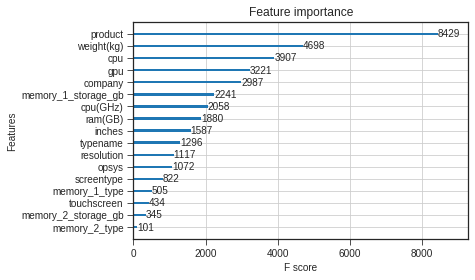

In [110]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, early_stopping_rounds=50)

In [111]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Wraper
def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testResults = []
    trainResults = []
    
    predictions = []
    
    indices = []
    
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Estimator:
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        predictions.append(testPred.tolist().copy())
        
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Info of each fold
        trainScore = np.round(r2_score(df[target].iloc[train], trainPred),4)*100
        testScore = np.round(r2_score(df[target].iloc[test], testPred),4)*100
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
          print("Train R2: {:.2f} %".format(trainScore),
                "Test R2: {:.2f} %".format(testScore))
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [121]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
    max_depth=8, subsample=0.7, colsample_bytree=0.7, lambdaX=4, gamma=0.1, debug=False, verbosity=0)
np.mean(trainResults), np.mean(testResults)

(99.52000000000001, 93.19800000000001)

In [124]:
import random
results=[]
paramList = []
for x in range(200):
    params = (random.randint(3, 9), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10), random.uniform(0.01, 0.25), random.uniform(0, 60))
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4],
        eta=params[5],
        min_child_weight=params[6])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)


70.252 (7, 0.4729875921928567, 0.5534699144777333, 8.958366345701844, 9.286355192133959, 0.21148669813567392, 38.546575373190066)
69.16799999999999 (3, 0.2508809459534046, 0.18541240165399905, 2.8017456652367736, 6.713140637608779, 0.15533140882894042, 8.135679802575934)
83.02 (6, 0.5959361831455378, 0.13036935717367815, 1.4748254190475696, 1.692944845554173, 0.21191777505622963, 49.12259502377074)
86.828 (4, 0.860044685085672, 0.5887839034490006, 4.011318396174407, 0.8474168771103208, 0.20917574523899135, 57.69047415556989)
81.508 (3, 0.6502896850744766, 0.7332484621069821, 2.080815767109301, 2.857692342847571, 0.1746552283589901, 18.25591600801011)
80.098 (7, 0.43267650585289363, 0.7587983519948857, 0.05799901266319574, 2.528081914614689, 0.04752117708379182, 51.00022105992933)
74.94 (3, 0.815381539125684, 0.5526134074117541, 3.217118939026932, 7.385221649124686, 0.11506020066366972, 55.11266801573325)
58.989999999999995 (3, 0.1932202675626825, 0.24109713790258738, 5.11075689319118, 

In [125]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(92.818, (6, 0.5935893782929406, 0.4212075192023417, 5.840540388883894, 0.0573000359188347, 0.035175423933932644, 10.033154995977846))
(92.248, (9, 0.8415870782252587, 0.3648725453249333, 8.126122193633432, 0.10743943612142148, 0.024708655108747788, 10.951503573510077))
(91.672, (5, 0.634811381416561, 0.4994040409415892, 9.383042958087733, 0.07068917461860558, 0.15017628223567123, 39.78033552828029))
(90.51999999999998, (8, 0.22846717766450358, 0.5048068226960888, 2.69574603976431, 0.23926782893714083, 0.13718989189419484, 1.9035006046345693))
(90.046, (9, 0.48242072022274174, 0.15667014164758974, 0.5545468073010862, 0.05484721197886677, 0.019903897920221264, 28.944470808305965))
(89.87199999999999, (8, 0.7722534670388107, 0.3718810412098521, 3.339139394462085, 0.428546367961371, 0.11724388066194436, 11.707925010238249))
(88.53, (4, 0.8270864507828515, 0.8081348708874961, 0.10469249792863344, 0.8294318002677559, 0.09370093141253112, 9.953399937755423))
(88.00999999999999, (4, 0.4850606

In [126]:
trainResults, testResults, predictions, indices, hists = CVTestXGB( 
    max_depth=6, subsample=0.5935893782929406, colsample_bytree=0.4212075192023417, lambdaX= 5.840540388883894, gamma= 0.0573000359188347, eta = 0.035175423933932644, min_child_weight = 10.033154995977846, debug=False, verbosity=0)
np.mean(trainResults), np.mean(testResults)

(96.80999999999999, 92.818)

Results after hyperparameter tuning are better than without it\
R2: 91.489 %
vs.
R2: 92.818 %

## Save the model

Let's save the model. I will later compare the performance of different models on the testing dataset

In [239]:
import pickle

In [129]:
model = xgb.XGBRegressor(max_depth=6, 
                         subsample=0.5935893782929406, 
                         colsample_bytree=0.4212075192023417, 
                         lambdaX= 5.840540388883894, 
                         gamma= 0.0573000359188347, 
                         eta = 0.035175423933932644, 
                         min_child_weight = 10.033154995977846)
model.fit(df[features], df[target])

[23:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4212075192023417, eta=0.035175423933932644,
             gamma=0.0573000359188347, lambdaX=5.840540388883894, max_depth=6,
             min_child_weight=10.033154995977846, subsample=0.5935893782929406)

In [131]:
pickle.dump(model, open('xgboost.sav', 'wb'))